In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

df=pd.read_excel('Guardia_Andrey/basemodelo.xlsx')

print(df.head())

    datetime  temperatura  precipitacion  caudal    Viento   niño  \
0 1983-07-01    33.586399       5.611070    8.79 -0.774190  27.18   
1 1983-08-01    32.744043       5.684166    9.06 -0.612899  26.59   
2 1983-09-01    32.169130       9.694898   10.50 -0.269997  26.20   
3 1983-10-01    31.440404       9.860561   13.20 -0.654835  25.56   
4 1983-11-01    31.184763       4.658684   13.80 -0.446662  25.41   

   caudal_lag_1m  caudal_lag_2m  caudal_lag_3m  caudal_lag_4m  ...  \
0           7.33           5.69           7.40           8.54  ...   
1           8.79           7.33           5.69           7.40  ...   
2           9.06           8.79           7.33           5.69  ...   
3          10.50           9.06           8.79           7.33  ...   
4          13.20          10.50           9.06           8.79  ...   

   temp_lag_3m  temp_lag_4m  temp_lag_5m  temp_lag_6m  prep_lag_1m  \
0    33.200055    33.356251    37.135195    35.070498     8.288372   
1    33.786155    33.200

In [28]:
x=df[["temperatura","precipitacion","Viento","niño","caudal_lag_1m","caudal_lag_2m","caudal_lag_3m","caudal_lag_4m"
      ,"caudal_lag_5m","caudal_lag_6m","temp_lag_1m","temp_lag_2m","temp_lag_3m","temp_lag_4m","temp_lag_5m","temp_lag_6m",
      "prep_lag_1m","prep_lag_2m","prep_lag_3m","prep_lag_4m","prep_lag_5m","prep_lag_6m"]]
y=df["caudal"]


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

x_esc = scaler_X.fit_transform(x)
y_esc = scaler_y.fit_transform(y.values.reshape(-1, 1))


In [43]:
#capa = tf.keras.layers.Dense(units=1,input_shape=(x_esc.shape[1],))
#modelo=tf.keras.Sequential([capa])

oculta1 = tf.keras.layers.Dense(units=23, input_shape=(22,))
oculta2 = tf.keras.layers.Dense(units=23)
oculta3 = tf.keras.layers.Dense(units=23)
salida = tf.keras.layers.Dense(units=1)
modelo = tf.keras.Sequential([oculta1, oculta2, oculta3, salida])

c:\Users\andre\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    loss="mean_squared_error"
)

In [45]:
print("Entrenamiento del Modelo")
historial = modelo.fit(x_esc,y_esc, epochs=1000, verbose=False)
print("Modelo Entrenado")

Entrenamiento del Modelo
Modelo Entrenado


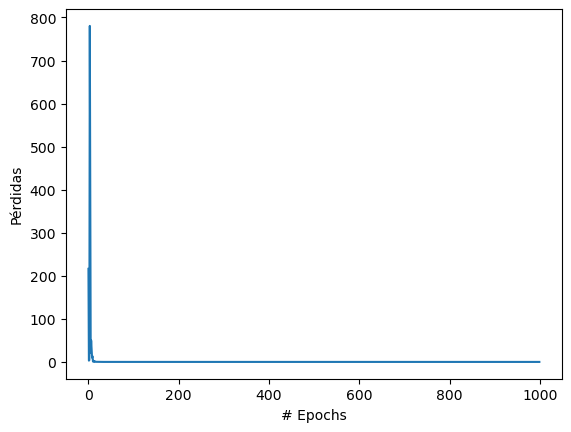

In [46]:
import matplotlib.pyplot as plt
plt.xlabel("# Epochs")
plt.ylabel("Pérdidas")
plt.plot(historial.history["loss"])

In [47]:
predictions_scaled = modelo.predict(x_esc)
predictions = scaler_y.inverse_transform(predictions_scaled).flatten()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_pred = predictions

# Evaluar métricas
rmse = np.sqrt(mean_squared_error(y, predictions))
mae = mean_absolute_error(y, predictions)
r2 = r2_score(y, predictions)


print(f"R²: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
R²: 0.6864061720721746
RMSE: 4.027764300985956
MAE: 2.104725547905626


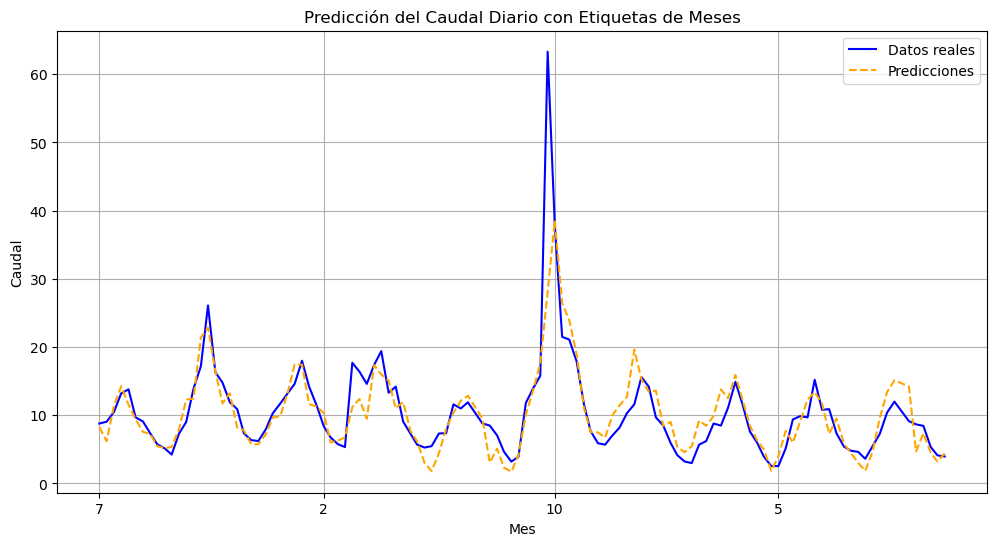

In [61]:
x["datetime"]=df["datetime"]
y["datetime"]=df["datetime"]



y_test_grouped = pd.DataFrame({'datetime': x['datetime'], 'Real': y}).groupby('datetime').mean()
predictions_grouped = pd.DataFrame({'datetime': x['datetime'], 'Prediccion': predictions}).groupby('datetime').mean()


resultados = y_test_grouped.merge(predictions_grouped, left_index=True, right_index=True)

resultados['Fecha'] = pd.to_datetime(resultados.index, format='%m-%d')


plt.figure(figsize=(12, 6))
plt.plot(resultados['Fecha'], resultados['Real'], label='Datos reales', color='blue')
plt.plot(resultados['Fecha'], resultados['Prediccion'], label='Predicciones', color='orange', linestyle='dashed')


plt.xticks(ticks=resultados['Fecha'][::31], labels=resultados['Fecha'][::31].dt.month)


plt.title('Predicción del Caudal Diario con Etiquetas de Meses')
plt.xlabel('Mes')
plt.ylabel('Caudal')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
print(x["datetime"].tail(10))

106   1992-06-01
107   1992-07-01
108   1992-08-01
109   1992-09-01
110   1992-11-01
111   1992-12-01
112   1993-01-01
113   1993-02-01
114   1993-03-01
115   1993-04-01
Name: datetime, dtype: datetime64[ns]


In [56]:
print("Variables Internas")
#print(capa.get_weights())
print(oculta1.get_weights())
print(oculta2.get_weights())
print(oculta3.get_weights())
print(salida.get_weights())

Variables Internas
[array([[-2.23313138e-01, -2.32064202e-01,  2.57536113e-01,
        -1.59267876e-02, -2.42013559e-01, -1.25954568e-01,
         6.67302534e-02,  2.22579807e-01,  5.70811689e-01,
         1.95734039e-01, -4.36412357e-02, -1.37664825e-01,
         1.92559347e-01,  1.60247400e-01, -1.86962076e-02,
        -3.22144449e-01, -1.96129635e-01,  4.34142739e-01,
         6.06682636e-02,  4.41856533e-01,  2.25967631e-01,
        -1.32768720e-01, -1.15041807e-01],
       [ 1.93028361e-01,  1.70746833e-01, -2.70021148e-02,
        -1.02249883e-01, -6.89872578e-02, -1.23694599e-01,
         6.49993122e-02,  6.02775872e-01,  4.13460702e-01,
         3.99014316e-02,  4.39627528e-01, -1.44331872e-01,
         3.25467169e-01,  5.67635559e-02,  6.20488763e-01,
        -6.32812977e-01, -4.36290503e-01,  3.44948247e-02,
         4.23914254e-01,  4.48860377e-01, -2.75146127e-01,
         1.76322222e-01, -4.99203019e-02],
       [-2.31487602e-01,  9.86977369e-02,  1.74906373e-01,
         